In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import linalg as LA
import pickle
import random

In [2]:
##Wavenumbers
k = 12 * np.pi
m = 6 * np.pi
m_U = 14 * np.pi #vertical wavenumber
##

r_m = 0.1
N0_squared = 100


k_e = np.sqrt(k**2 + m**2)
k_plus = np.sqrt(k**2 +(m+m_U)**2)

W_e = np.array([[-1, k / (k_e**2)],
                [-k * N0_squared, -1]])
W_plus = np.array([[-1, -k / (k_plus**2)],
                [k * N0_squared, -1]])

W = np.block([[W_e, np.zeros((2, 2))],
             [np.zeros((2, 2)), W_plus]])

L_e = np.array([[-(k*(k_plus**2 - m_U**2)) / (2 * (k_e**2)), 0],
                [0, k / 2]])

L_plus = np.array([[-(k*(m_U**2 - k_e**2)) / (2 * (k_plus**2)), 0],
                [0, -k / 2]])

L = np.block([[np.zeros((2, 2)), L_e],
             [L_plus, np.zeros((2, 2))]])

In [3]:
dt = 0.01

T = 150

t = np.linspace(0,T,int(T/dt)+1)

C = np.zeros((4,4,len(t)))

U = np.zeros((len(t),1))

Q = np.zeros((4,4,len(t)))

Q[0, 0] = 8 / (k_e**2)

epsilon = 0.01

r_m = 0.1
N0_squared = 100

C[:,:,0] = 0

U[0] = 0.001

def rhs(t, U_and_C, r_m, W, L, epsilon, Q):
    U = U_and_C[0]
    C = U_and_C[1:].reshape(4, 4)
    A = W + U*L
    R = C[0, 2]*(0.25 * k * ((k_plus**2) - (k_e**2)))
    dCdt = A @ C + C @ A.T + epsilon*Q
    return np.array([-r_m*U + R, *dCdt.flatten()])

def rk4_method(rhs, y0, t_span, dt, *args):
    
    t0, tf = t_span
    t = np.linspace(t0, tf, int((tf - t0) / dt) + 1)
    y = np.zeros((len(y0), len(t)))
    y[:, 0] = y0

    for i in range(1, len(t)):
        k1 = rhs(t[i-1], y[:, i-1], *args)
        k2 = rhs(t[i-1] + dt/2, y[:, i-1] + dt/2 * k1, *args)
        k3 = rhs(t[i-1] + dt/2, y[:, i-1] + dt/2 * k2, *args)
        k4 = rhs(t[i-1] + dt, y[:, i-1] + dt * k3, *args)

        y[:, i] = y[:, i-1] + dt * (k1 + 2*k2 + 2*k3 + k4) / 6

    return t, y

U0 = 0.001
C0 = np.zeros((4, 4))
initial_conditions = np.array([U0, *C0.flatten()])

# Solve the ODE system using rk4_method
t, solution = rk4_method(rhs, initial_conditions, (0, T), dt, r_m, W, L, epsilon, Q[:,:,0])


U = solution[0, :]
C = solution[1:].reshape(4, 4, len(t))

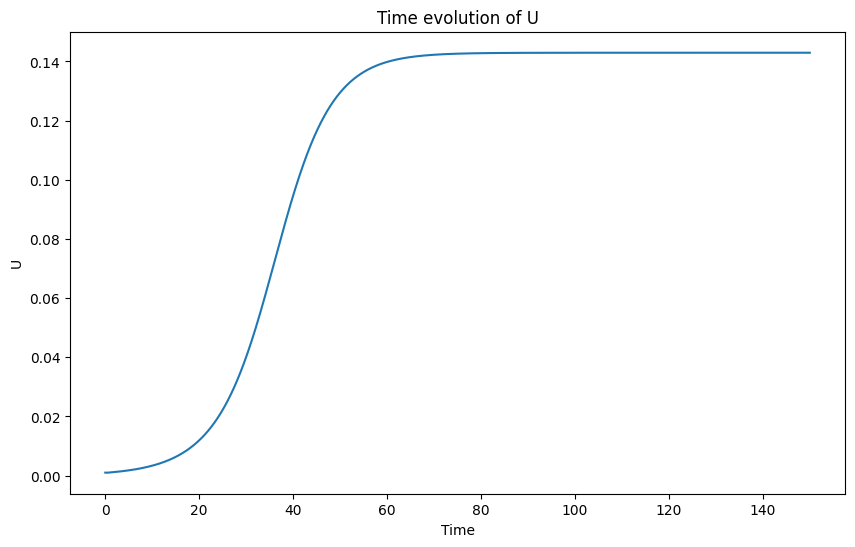

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(t, U)
plt.xlabel('Time')
plt.ylabel('U')
plt.title('Time evolution of U')
plt.show()

In [5]:
C.shape

(4, 4, 15001)

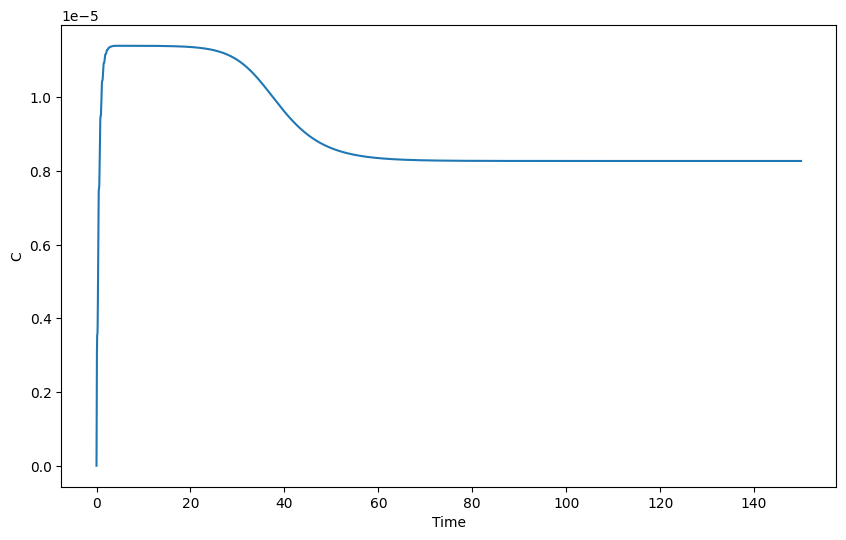

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(t, C[0,0,:], label='C1')
plt.xlabel('Time')
plt.ylabel('C')
plt.show()

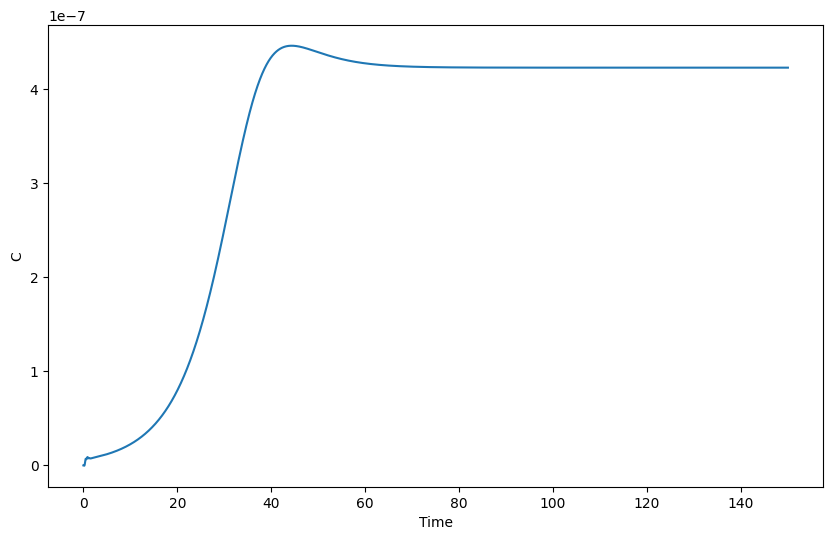

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(t, C[0,2,:], label='C1')
plt.xlabel('Time')
plt.ylabel('C')
plt.show()

In [8]:
U_final = U[-1,]
C_final = C[:,:,-1]

In [9]:
print(U_final)
print(C_final)

0.1429557658856964
[[ 8.26860079e-06 -5.67731744e-04  4.22210896e-07 -7.52375921e-04]
 [-5.67731744e-04  1.49938478e+00 -4.71980217e-05 -2.37846411e-01]
 [ 4.22210896e-07 -4.71980217e-05  5.33915679e-07 -8.08053021e-05]
 [-7.52375921e-04 -2.37846411e-01 -8.08053021e-05  3.36284662e-01]]


In [10]:
# C_noise = C_final + np.random.normal(0, 1, (4, 4))

In [11]:
C_noise = np.zeros((4,4))

for i in range(4):
    for j in range(4):
        C_noise[i,j] = C_final[i,j] + C_final[i,j] * 0.05 * ([-1,1][random.randrange(2)])

U_noise = U_final + U_final * 0.05 * ([-1,1][random.randrange(2)])

In [12]:
dt = 0.01

T = 150

t = np.linspace(0,T,int(T/dt)+1)

C = np.zeros((4,4,len(t)))

U = np.zeros((len(t),1))

Q = np.zeros((4,4,len(t)))

Q[0, 0] = 8 / (k_e**2)

epsilon = 0.01

r_m = 0.1
N0_squared = 100

def rhs(t, U_and_C, r_m, W, L, epsilon, Q):
    U = U_and_C[0]
    C = U_and_C[1:].reshape(4, 4)
    A = W + U*L
    R = C[0, 2]*(0.25 * k * ((k_plus**2) - (k_e**2)))
    dCdt = A @ C + C @ A.T + epsilon*Q
    return np.array([-r_m*U + R, *dCdt.flatten()])

def rk4_method(rhs, y0, t_span, dt, *args):
    
    t0, tf = t_span
    t = np.linspace(t0, tf, int((tf - t0) / dt) + 1)
    y = np.zeros((len(y0), len(t)))
    y[:, 0] = y0

    for i in range(1, len(t)):
        k1 = rhs(t[i-1], y[:, i-1], *args)
        k2 = rhs(t[i-1] + dt/2, y[:, i-1] + dt/2 * k1, *args)
        k3 = rhs(t[i-1] + dt/2, y[:, i-1] + dt/2 * k2, *args)
        k4 = rhs(t[i-1] + dt, y[:, i-1] + dt * k3, *args)

        y[:, i] = y[:, i-1] + dt * (k1 + 2*k2 + 2*k3 + k4) / 6

    return t, y

U0 = U_noise
C0 = C_noise
initial_conditions = np.array([U0, *C0.flatten()])

# Solve the ODE system using rk4_method
t, solution = rk4_method(rhs, initial_conditions, (0, T), dt, r_m, W, L, epsilon, Q[:,:,0])


U = solution[0, :]
C = solution[1:].reshape(4, 4, len(t))

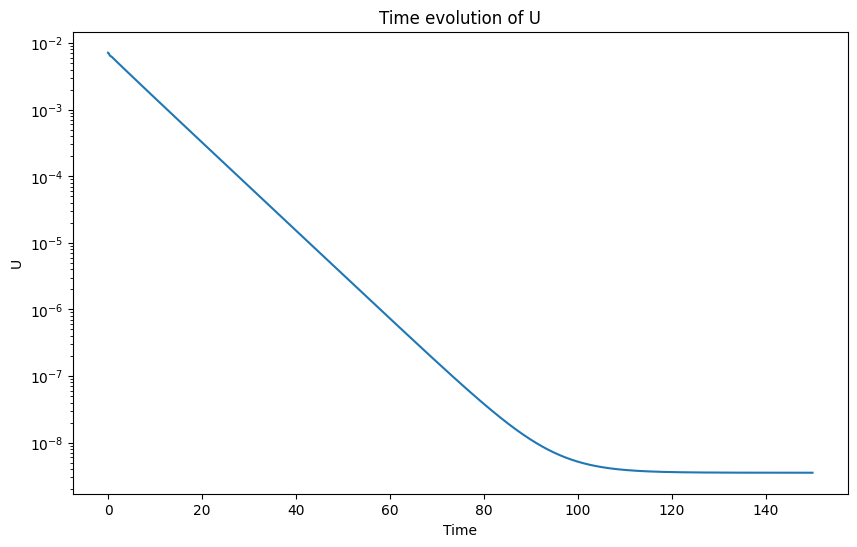

In [13]:
plt.figure(figsize=(10, 6))
# plt.plot(t, U)
plt.semilogy(t, U-U_final)
plt.xlabel('Time')
plt.ylabel('U')
plt.title('Time evolution of U')
plt.show()

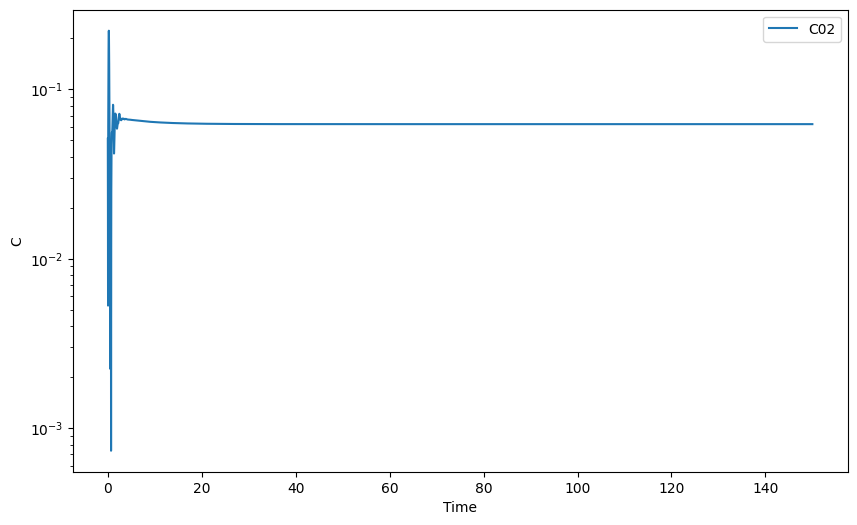

In [14]:
plt.figure(figsize=(10, 6))
plt.semilogy(t, np.abs(C[0,2,:]-C_final[0,2])/np.abs(C[0,0,:]-C_final[0,0]), label='C02')
plt.xlabel('Time')
plt.ylabel('C')
plt.legend()
# plt.xlim(0,10)
plt.show()

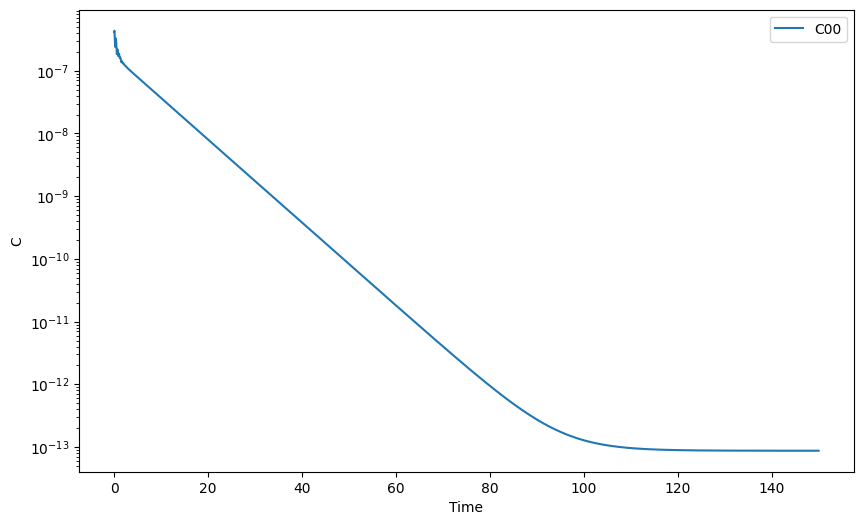

In [15]:
plt.figure(figsize=(10, 6))
plt.semilogy(t, np.abs(C[0,0,:]-C_final[0,0]), label='C00')
plt.xlabel('Time')
plt.ylabel('C')
plt.legend()
plt.show()

In [16]:
# U_final = U[-1,]
# C_final = C[:,:,-1]

In [17]:
# print(U_final)
# print(C_final)

In [18]:
U_25 = U[25*100] - U_final
U_50 = U[50*100] - U_final
print(U_25)
print(U_50)

0.00015070461895699827
3.3489408182707514e-06


In [19]:
lambda_val = (1/25) *np.log(U_25/U_50)

In [20]:
timescale = 1/lambda_val
print('The timescale is: ', timescale)

The timescale is:  6.567406649669347


In [21]:
U_noise

0.1501035541799812

In [22]:
R = 0.25 * k * (k_plus**2 - k_e**2) * (C[0,2,:]-C_final[0,2])

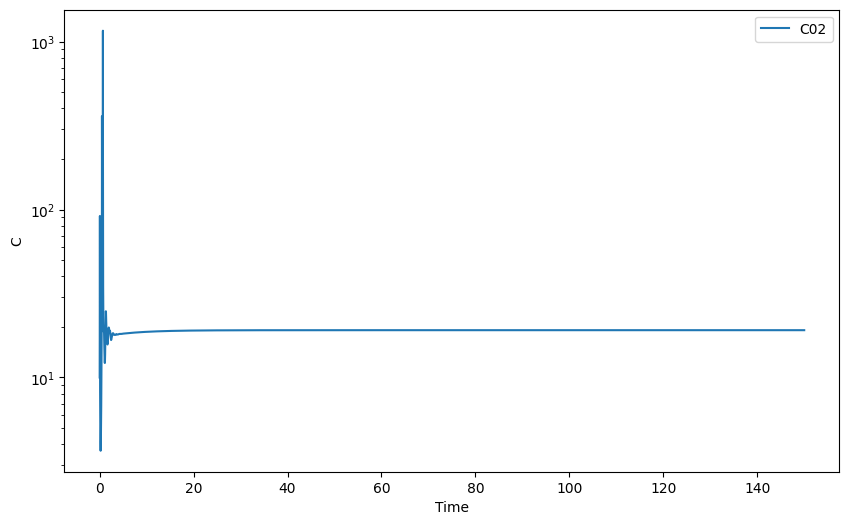

In [23]:
plt.figure(figsize=(10, 6))
plt.semilogy(t, np.abs(U-U_final)/np.abs(R), label='C02')
plt.xlabel('Time')
plt.ylabel('C')
plt.legend()
# plt.xlim(0,20)
plt.show()

In [24]:
np.mean(np.abs(U-U_final)/np.abs(R))

19.216123376075537

In [25]:
final_val = np.abs(U-U_final)/np.abs(R)

In [26]:
final_val[-1]

19.12866336908431

In [27]:
R_final = 0.25 * k * (k_plus**2 - k_e**2) * C_final[0,2]

In [29]:
with open("variables_eigen.pickle", "wb") as f:
    pickle.dump((R_final, U_final, U_noise, C_noise), f)